In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [3]:
df = pd.read_excel(r'G:\25国赛\C题\PythonProject\code1\Data1_WeekToDay.xlsx')
df['检测孕周'] = df['检测孕周'] / 7

X = df[['检测孕周','孕妇BMI','年龄']]
y = df['Y染色体浓度']

y_log = np.log(y)
X_trans = X.copy()
X_trans['age2'] = X_trans['年龄'] **2
X_trans['log检测孕周'] = np.log(X_trans['检测孕周'])
X_trans['BMI_2'] = np.power(X_trans['孕妇BMI'], 2)
X_trans['BMI*GA'] = X_trans['孕妇BMI'] * X_trans['检测孕周']
X_trans['BMI_centered'] = X_trans['孕妇BMI'] - X_trans['孕妇BMI'].mean()
X_trans['logGA*BMI_centered'] = X_trans['log检测孕周'] * X_trans['BMI_centered']
X_trans['BMI_centered_sq'] = X_trans['BMI_centered'] ** 2
X_trans = X_trans[['检测孕周', '孕妇BMI','BMI_centered_sq','年龄']]

# X_trans = sm.add_constant(X_trans)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=2)

# model = sm.OLS(y_log, X_trans).fit()
# print(model.summary())

# degree = 2  # 多项式阶数（根据数据特点调整）
# poly = PolynomialFeatures(degree=degree,)
# # 转换特征：生成X1, X2, X1², X1X2, X2², X1³, X1²X2, X1X2², X2³等项
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.transform(X_test)


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


r2 = r2_score(y_test, y_pred)

# print(f"系数: {model.params[1:]}")
# print(f"截距: {model.params[0]}")
print(f"系数: {model.coef_}")
print(f"截距: {model.intercept_}")
print(f"R²（决定系数）：{r2:.4f}")

系数: [ 0.00125591 -0.00144787 -0.00018168 -0.00110431]
截距: 0.13629385289629597
R²（决定系数）：0.1050


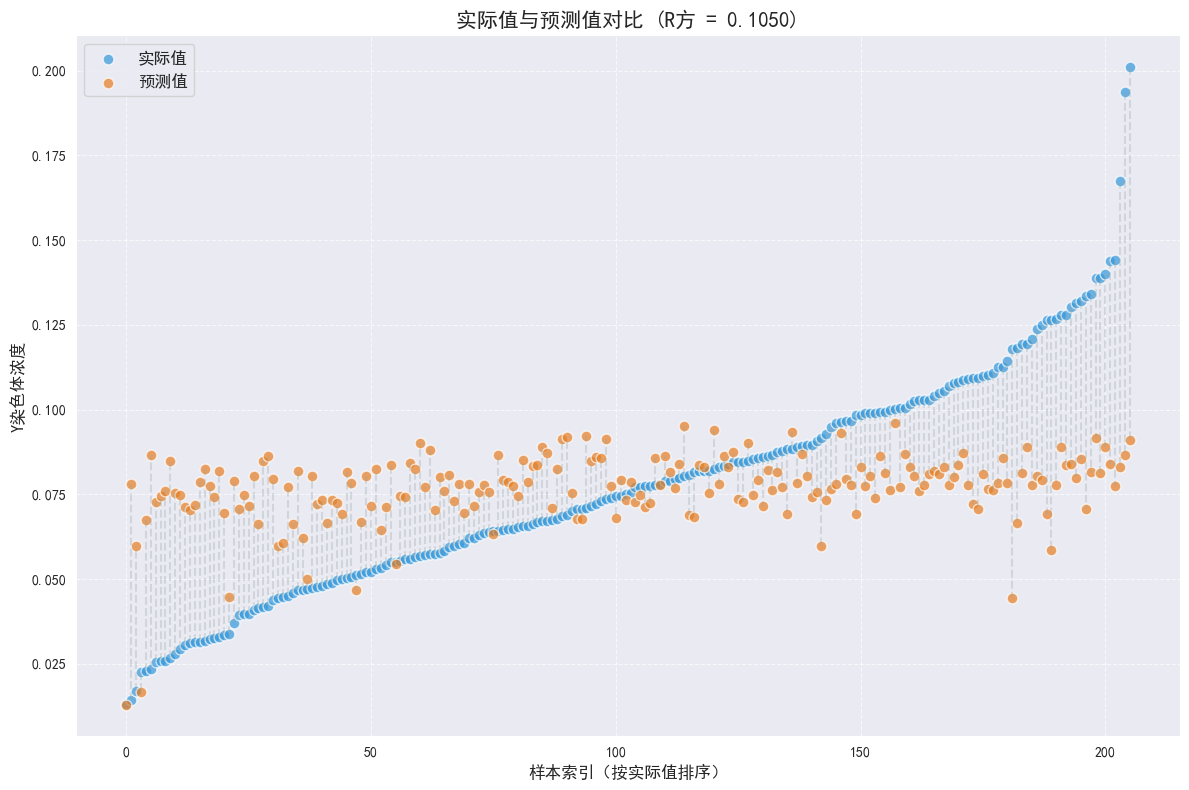

In [11]:
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
indices = np.argsort(y_test)
y_test_sorted = y_test.iloc[indices]
y_pred_sorted = y_pred[indices]

# 绘制图形
plt.figure(figsize=(12, 8))

plt.scatter(range(len(y_test_sorted)), y_test_sorted,
           color='#3498db', alpha=0.7, label='实际值', s=60, edgecolors='white')

plt.scatter(range(len(y_pred_sorted)), y_pred_sorted,
           color='#e67e22', alpha=0.7, label='预测值', s=60, edgecolors='white')


for i in range(len(y_test_sorted)):
    plt.plot([i, i], [y_test_sorted.iloc[i], y_pred_sorted[i]],
             color='#95a5a6', alpha=0.3, linestyle='--')          # 添加连接线，表示实际值与预测值之间的差距

plt.title(f'实际值与预测值对比 (R方 = {r2:.4f})', fontsize=15)
plt.xlabel('样本索引（按实际值排序）', fontsize=12)
plt.ylabel('Y染色体浓度', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)  #图例

plt.tight_layout()

plt.savefig(
    '实际值VS预测值.png',
    dpi=300,
    bbox_inches='tight',
)

plt.show()


In [44]:
coef = np.hstack([model.intercept_, model.coef_])
feature_names = ['const'] + X_trans.columns.tolist()

In [45]:
def f_test(model, X, y):

    n = len(y)
    p = X.shape[1]

    # 预测值
    y_pred = model.predict(X)

    sst = np.sum((y - np.mean(y)) **2)

    ssr = np.sum((y_pred - np.mean(y))** 2)

    sse = np.sum((y - y_pred) **2)

    df_regression = p
    df_residual = n - p - 1

    f_stat = (ssr / df_regression) / (sse / df_residual)

    f_pvalue = 1 - stats.f.cdf(f_stat, df_regression, df_residual)

    return {
        'F统计量': f_stat,
        'p值': f_pvalue,
        '结论': "模型整体显著（p<0.05）" if f_pvalue < 0.05 else "模型整体不显著（p≥0.05）"
    }

# 执行F检验
f_result = f_test(model, X_train, y_train)
print("=== 整体模型显著性检验（F检验） ===")
for key, value in f_result.items():
    print(f"{key}: {value:.6f}" if isinstance(value, float) else f"{key}: {value}")

=== 整体模型显著性检验（F检验） ===
F统计量: 12.996070
p值: 0.000000
结论: 模型整体显著（p<0.05）


In [46]:
def t_test(model, X, y):


    n = len(y)
    p = X.shape[1]

    y_pred = model.predict(X)
    residuals = y - y_pred

    sigma_sq = np.sum(residuals** 2) / (n - p - 1)

    X_with_const = np.hstack([np.ones((n, 1)), X])

    xtx = np.dot(X_with_const.T, X_with_const)
    xtx_inv = np.linalg.inv(xtx)

    se = np.sqrt(sigma_sq * np.diag(xtx_inv))

    t_stats = coef / se

    df = n - p - 1
    t_pvalues = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))

    result = pd.DataFrame({
        '变量': feature_names,
        '系数': coef,
        '标准误差': se,
        't统计量': t_stats,
        'p值': t_pvalues,
        '显著性': ['显著' if p < 0.05 else '不显著' for p in t_pvalues]
    })
    return result

t_result = t_test(model, X_train, y_train)
print("\n=== 单个系数显著性检验（t检验） ===")
print(t_result.round(6))


=== 单个系数显著性检验（t检验） ===
                变量        系数      标准误差      t统计量        p值 显著性
0            const  0.136294  0.016260  8.382308  0.000000  显著
1             检测孕周  0.001256  0.000285  4.400774  0.000012  显著
2            孕妇BMI -0.001448  0.000413 -3.506019  0.000480  显著
3  BMI_centered_sq -0.000182  0.000069 -2.632191  0.008644  显著
4               年龄 -0.001104  0.000310 -3.564791  0.000385  显著


In [47]:
def calculate_vif(X):

    vif = []
    for i in range(X.shape[1]):
        xi = X.iloc[:, i].values.reshape(-1, 1)
        x_rest = X.drop(X.columns[i], axis=1).values
        r2 = r2_score(xi, LinearRegression().fit(x_rest, xi).predict(x_rest))
        vif_i = 1 / (1 - r2)
        vif.append(vif_i)
    return pd.DataFrame({
        '变量': X.columns,
        'VIF': vif,
        '共线性程度': ['低' if v <= 5 else '中' if v <= 10 else '高' for v in vif]
    })

vif_result = calculate_vif(X_train)
print("\n=== 多重共线性检验（VIF） ===")
print(vif_result.round(2))


=== 多重共线性检验（VIF） ===
                变量   VIF 共线性程度
0             检测孕周  1.03     低
1            孕妇BMI  1.10     低
2  BMI_centered_sq  1.10     低
3               年龄  1.00     低
